# Compute the global score

The aim of this notebook is to demonstrate how to compute the global score to evaluate the performance for a given model (aka `AugmentedSimulator`). This notebook is composed of three main parts:

- [Acceleration reference computation](#acceleration) we show how the acceleration factor is obtained wrt the reference simulator
- [Score computation step-by-step](#step-by-step) we disentangle the score computation throughout a real example
- [Automatic Score Computation for local submissions](#auto-score) we provide a function which computes the score from a trained model or from saved metrics

For more information concerning the computation of the score, the readers could refer to [this file](Evaluation.md).

#### Import required packages

In [169]:
import os
import math

## Acceleration reference computation <a id="acceleration"></a>

As the acceleration of simulation is one of the most important criteria in this competition, in this section we try to explain with respect to which reference the acceleration will be computed.

#### Using AC Power Flow simulator (LightSim2Grid)

- The reference in this competition is the physical solver based on Newton Raphson optimisation which is implemented in  [LightSim2Grid](https://github.com/BDonnot/lightsim2grid) and called through [Grid2op](https://github.com/rte-france/Grid2Op) framework. It solves the power flow equations in AC power system. We first provide a function which return the corresponding computation time for an indicated number of simulated samples.

Get the AC solver time (used as the reference) with respect to which the acceleration rate is computed.

In [170]:
from lips.metrics.power_grid.compute_solver_time_grid2op import compute_solver_time_grid2op

BENCH_CONFIG_PATH = os.path.join("configs", "benchmarks", "lips_idf_2023.ini")
grid2op_solver_time = compute_solver_time_grid2op(config_path=BENCH_CONFIG_PATH, benchmark_name="Benchmark_competition", nb_samples=int(1e5))

100%|██████████| 1000/1000 [00:26<00:00, 37.69it/s]

Time required to solve one power flow:  0.0003269047848880291
Time required to solve 100000 power flows:  32.69047848880291


#### Using Security Analysis

However, a more optimized way to compute the power flow for the risk assessment application is through the security analysis. It runs simulations on a grid state for every contingency of interest in terms of risk, more especially for every single line disconnection that could unexpectdly occur. It hence runs as many simulations as there are lines on the grid in a single computation. Compared to single powerflow computation, this is accelerated thanks to matrix decomposition and factorization that is only done once and reused all along the contingency simulations. 

This Security Analysis computation is used as a baseline for this risk assessment application of interest in this competition.

In [39]:
from lips.config import ConfigManager
from lips.metrics.power_grid.compute_solver_time import compute_solver_time

BENCH_CONFIG_PATH = os.path.join("configs", "benchmarks", "lips_idf_2023.ini")
config = ConfigManager(path=BENCH_CONFIG_PATH, section_name="Benchmark_competition")

sa_solver_time = compute_solver_time(nb_samples=int(1e5), config=config)

In [40]:
sa_solver_time

8.627058052987502

In [20]:
print(f"The acceleration obtained using Security Analysis is :  {(grid2op_solver_time / sa_solver_time):.2f} times")

The acceleration obtained using Security Analysis is :  3.77 times


## Score computation step-by-step <a id='step-by-step'></a>
Hereafter, we provide the score computation procedure for the submissions. We start by an example of metrics returned by a baseline approach on `lips_idf_2023` environment. 

For more information about the metrics, you can refer to the LIPS paper Appendix.

We yet highlight the use of a specific metric: the MAPE90. As in risk assessment, we are interested to detect overloads on the lines, we only compute the MAPE on for currents on the last 10% quantile.

Once overloads are detected, an operator still needs to picture the flows on this state. Hence we assess the active power on the almost complete distribution, except the very low values which are not very significant. Hence the use of MAPE10 in that case.

In [244]:
test_metrics = {"ML":{"a_or":0.013, # MAPE90 
                      "a_ex":0.013, # MAPE90 
                      "p_or":0.029, # MAPE10 
                      "p_ex":0.029, # MAPE10 
                      "v_or":1.11, # MAE
                      "v_ex":1.11  # MAE
                },
                "Physics":{
                      "CURRENT_POS": 0.2,
                      "VOLTAGE_POS": 0.1,
                      "LOSS_POS": 27.88,
                      "DISC_LINES": 100.0,
                      "CHECK_LOSS": 1.54,
                      "CHECK_GC": 99.99,
                      "CHECK_LC": 98.55,
                      "CHECK_JOULE_LAW": 85.84                      
                }
               }

test_ood_metrics = {"ML":{"a_or":0.024, # MAPE90 
                          "a_ex":0.024, # MAPE90 
                          "p_or":0.041, # MAPE10 
                          "p_ex":0.040, # MAPE10 
                          "v_or":2.28, # MAE
                          "v_ex":2.07  # MAE
                    },
                    "Physics":{
                          "CURRENT_POS": 0.4, # violation percentage (%)
                          "VOLTAGE_POS": 0.1,
                          "LOSS_POS": 30.88,
                          "DISC_LINES": 100.0,
                          "CHECK_LOSS": 4.63,
                          "CHECK_GC": 99.99,
                          "CHECK_LC": 98.70,
                          "CHECK_JOULE_LAW": 88.48 
                    }
                   } 

speed_up = grid2op_solver_time / 2.74 # 2.74 is the inference time of a Neural Network based approach

We define the acceptability thresholds. Each variable is associated with 2 thresholds used to determine whether the result are great, acceptable or unacceptable and whether the result should be maximized or minimized.

In [245]:
thresholds={"a_or":(0.02,0.05,"min"),
            "a_ex":(0.02,0.05,"min"),
            "p_or":(0.02,0.05,"min"),
            "p_ex":(0.02,0.05,"min"),
            "v_or":(0.2,0.5,"min"),
            "v_ex":(0.2,0.5,"min"),
            "CURRENT_POS":(1., 5.,"min"),
            "VOLTAGE_POS":(1.,5.,"min"),
            "LOSS_POS":(1.,5.,"min"),
            "DISC_LINES":(1.,5.,"min"),
            "CHECK_LOSS":(1.,5.,"min"),
            "CHECK_GC":(0.05,0.10,"min"),
            "CHECK_LC":(0.05,0.10,"min"),
            "CHECK_JOULE_LAW":(1.,5.,"min")
           }

For instance, regarding the value obtained for the variable 'a_or'

- if it is lower than 2%, the result is great
- if it is greater than 2% but lower than 5%, the result is acceptable
- if it is greater than 5%, the result is not acceptable

For a physical criteria `CHECK_GC` (check global conservation):

- if the violation is less than 5 percent, the result is acceptable
- if it is greater than 5 percent but lower than 10 percent, the result is acceptable
- if it is greater than 10 percent, the result is not acceptable

We also define the configuration which are the coefficients considered for each category and subcategories.

In [246]:
configuration={
    "coefficients":{"test":0.3, "test_ood":0.3, "speed_up":0.4},
    "test_ratio":{"ml": 0.66, "physics":0.34},
    "test_ood_ratio":{"ml": 0.66, "physics":0.34},
    "value_by_color":{"g":2,"o":1,"r":0},
    "max_speed_ratio_allowed":50
}

We evaluate the result accuracy performances for all variables. We denote by:

- g, a great result
- o, an acceptable result
- r, a not acceptable result

In [247]:
results_test=dict()
for subcategoryName, subcategoryVal in test_metrics.items():
    results_test[subcategoryName]=[]
    for variableName, variableError in subcategoryVal.items():
        thresholdMin,thresholdMax,evalType=thresholds[variableName]
        if evalType=="min":
            if variableError<thresholdMin:
                accuracyEval="g"
            elif thresholdMin<variableError<thresholdMax:
                accuracyEval="o"
            else:
                accuracyEval="r"
        elif evalType=="max":
            if variableError<thresholdMin:
                accuracyEval="r"
            elif thresholdMin<variableError<thresholdMax:
                accuracyEval="o"
            else:
                accuracyEval="g"

        results_test[subcategoryName].append(accuracyEval)
    
print(results_test)

{'ML': ['g', 'g', 'o', 'o', 'r', 'r'], 'Physics': ['g', 'g', 'r', 'r', 'o', 'r', 'r', 'r']}


the same for OOD dataset

In [249]:
results_test_ood=dict()
for subcategoryName, subcategoryVal in test_ood_metrics.items():
    results_test_ood[subcategoryName]=[]
    for variableName, variableError in subcategoryVal.items():
        thresholdMin,thresholdMax,evalType=thresholds[variableName]
        if evalType=="min":
            if variableError<thresholdMin:
                accuracyEval="g"
            elif thresholdMin<variableError<thresholdMax:
                accuracyEval="o"
            else:
                accuracyEval="r"
        elif evalType=="max":
            if variableError<thresholdMin:
                accuracyEval="r"
            elif thresholdMin<variableError<thresholdMax:
                accuracyEval="o"
            else:
                accuracyEval="g"

        results_test_ood[subcategoryName].append(accuracyEval)
    
print(results_test_ood)

{'ML': ['o', 'o', 'o', 'o', 'r', 'r'], 'Physics': ['g', 'g', 'r', 'r', 'o', 'r', 'r', 'r']}


In [263]:
def quadratic_function(x, a, b, c, k):
    if x == 1.:
        return 0.
    else:
        return a*(x**2) + b*x + c + math.log10(k*x)

def SpeedMetric(speedUp, speedMax):
    a=0.01 # 0.01
    b=0.5 #0.5
    c=0.1 #0.1
    k=9
    res = quadratic_function(speedUp, a=a, b=b, c=c, k=k) / quadratic_function(speedMax, a=a, b=b, c=c, k=k)
    return max(min(res, 1), 0)

In [251]:
coefficients = configuration["coefficients"]
test_ratio = configuration["test_ratio"]
test_ood_ratio = configuration["test_ood_ratio"]
value_by_color = configuration["value_by_color"]
max_speed_ratio_allowed = configuration["max_speed_ratio_allowed"]

### Test dataset:

- ML

In [252]:
test_ml_subscore=0

test_ml_res = sum([value_by_color[color] for color in results_test["ML"]])
test_ml_res = (test_ml_res * test_ratio["ml"]) / (len(results_test["ML"])*max(value_by_color.values()))
test_ml_subscore += test_ml_res

- Physics:

In [253]:
test_physics_res = sum([value_by_color[color] for color in results_test["Physics"]])
test_physics_res = (test_physics_res*test_ratio["physics"]) / (len(results_test["Physics"])*max(value_by_color.values()))
test_physics_subscore = test_physics_res

In [262]:
test_subscore = test_ml_subscore + test_physics_subscore
print(f"Test dataset subscore (ML + Physics) : {test_subscore:.2f}")

Test dataset subscore (ML + Physics) : 0.44


### Speed up

In [261]:
speedup_score = SpeedMetric(speedUp=speed_up,speedMax=max_speed_ratio_allowed)
print(f"Speed-up score: {speedup_score:.2f}")

Speed-up score: 0.18


### Test OOD

- ML

In [256]:
test_ood_ml_subscore=0

test_ood_ml_res = sum([value_by_color[color] for color in results_test_ood["ML"]])
test_ood_ml_res = (test_ood_ml_res * test_ood_ratio["ml"]) / (len(results_test_ood["ML"])*max(value_by_color.values()))
test_ood_ml_subscore += test_ood_ml_res

- Physics

In [257]:
test_ood_physics_res = sum([value_by_color[color] for color in results_test_ood["Physics"]])
test_ood_physics_res = (test_ood_physics_res*test_ood_ratio["physics"]) / (len(results_test_ood["Physics"])*max(value_by_color.values()))
test_ood_physics_subscore = test_ood_physics_res

In [260]:
test_ood_subscore = test_ood_ml_subscore + test_ood_physics_subscore
print(f"OOD dataset score (ML + Physics):  {test_ood_subscore:.2f}")

OOD dataset score (ML + Physics):  0.33


- Global Score

In [259]:
globalScore=100*(coefficients["test"]*test_subscore+coefficients["test_ood"]*test_ood_subscore+coefficients["speed_up"]*speedup_score)
print(globalScore)

30.093348207718172


## Automatic Score Computation for local submissions <a id='auto-score'></a>

In this section, we use the scoring function (available under `utils.compute_score`) in two ways:  
- to compute the score for already trained baseline models;
- to compute the score on the basis of the saved evaluation results (dictionary).

### Compute the score using an already trained model

Evaluate an already trained baseline (a fully connected architecture) and get the corresponding score using `compute_score` function.

In [7]:
### Import required packages
import os
from lips.benchmark.powergridBenchmark import PowerGridBenchmark

#Define the required paths
BENCH_CONFIG_PATH = os.path.join("configs", "benchmarks", "lips_idf_2023.ini")
DATA_PATH = os.path.join("input_data_local", "lips_idf_2023")
TRAINED_MODELS = os.path.join("input_data_local", "trained_models")
LOG_PATH = "logs.log"

benchmark_kwargs = {"attr_x": ("prod_p", "prod_v", "load_p", "load_q"),
                    "attr_y": ("a_or", "a_ex", "p_or", "p_ex", "v_or", "v_ex"),
                    "attr_tau": ("line_status", "topo_vect"),
                    "attr_physics": None}

benchmark = PowerGridBenchmark(benchmark_path=DATA_PATH,
                               config_path=BENCH_CONFIG_PATH,
                               benchmark_name="Benchmark_competition",
                               load_data_set=True, 
                               log_path=LOG_PATH,
                               **benchmark_kwargs)

In [2]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

memory_limit = 20000

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
  except RuntimeError as e:
    print(e)

In [ ]:
# load an already trained augmented simulator
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.dataset.scaler import StandardScaler

# Indicate the path required for corresponding augmented simulator parameters
SIM_CONFIG_PATH = os.path.join("configs", "simulators", "tf_fc.ini")

tf_fc = TfFullyConnected(name="tf_fc",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark_competition",
                         bench_kwargs=benchmark_kwargs,
                         sim_config_path=SIM_CONFIG_PATH,
                         sim_config_name="DEFAULT",
                         scaler=StandardScaler,
                         log_path=LOG_PATH)

LOAD_PATH = os.path.join(TRAINED_MODELS, "lips_idf_2023")
tf_fc.restore(path=LOAD_PATH)

In [ ]:
EVALUATION_PATH = os.path.join("input_data_local", "eval_results", "lips_idf_2023")
metrics = benchmark.evaluate_simulator(augmented_simulator=tf_fc,
                                       eval_batch_size=128,
                                       dataset="all",
                                       shuffle=False,
                                       save_path=EVALUATION_PATH,
                                       save_predictions=False
                                      )

In [196]:
# read the already saved results
EVALUATION_PATH = os.path.join("input_data_local", "eval_results", "lips_idf_2023", "tf_fc_DEFAULT")
metrics_dict = dict()
metrics_dict["test"] = import_metrics(EVALUATION_PATH, "test")
metrics_dict["test_ood_topo"] = import_metrics(EVALUATION_PATH, "test_ood_topo")

In [174]:
from utils.compute_score import compute_global_score
score = compute_global_score(metrics, benchmark.config)

100%|██████████| 1000/1000 [00:19<00:00, 50.50it/s]

Time required to solve one power flow:  0.0003298692740499973
Time required to solve 100000 power flows:  32.98692740499973
22.43482332440552


In [163]:
from utils.compute_score import configuration, reconstruct_metric_dict, discretize_results

coefficients = configuration["coefficients"]

test_metrics = reconstruct_metric_dict(metrics, "test")
test_ood_metrics = reconstruct_metric_dict(metrics, "test_ood_topo")

test_results_disc = discretize_results(test_metrics)
test_ood_results_disc = discretize_results(test_ood_metrics)

In [165]:
print(test_results_disc)
test_score = ((4 / 12) *  0.66) * 0.3 + ((5/16) * 0.34) * 0.3
print("Test dataset score: ", test_score)

{'ML': ['o', 'o', 'r', 'r', 'o', 'o'], 'Physics': ['g', 'g', 'r', 'r', 'o', 'r', 'r', 'r']}
Test dataset score:  0.097875


In [167]:
print(test_ood_results_disc)
test_ood_score = ((0 / 12) *  0.66) * 0.3 + ((5/16) * 0.34) * 0.3
print("OOD dataset score: ", test_ood_score)

{'ML': ['r', 'r', 'r', 'r', 'r', 'r'], 'Physics': ['g', 'g', 'r', 'r', 'o', 'r', 'r', 'r']}
OOD dataset score:  0.031875


In [171]:
from utils.compute_score import NewSpeedMetric

speed_up = grid2op_solver_time / metrics["test"]["ML"]["TIME_INF"]
print("The acceleration factor is: ", speed_up)

speedup = NewSpeedMetric(speed_up, 50)
speedup_score = speedup * .34
print("The speed-up score using the new metric is: ", speedup_score)

The acceleration factor is:  15.453827451532758
The speed-up score using the new metric is:  0.07965118789210594


In [172]:
test_score + test_ood_score + speedup_score

0.20940118789210593

### Compute the score using the saved evaluation results

Read the evaluation results for the baseline architecture (LeapNet architecture in this case).

In [5]:
import os
import json

def import_metrics(path, dataset):
    path_to_results = os.path.join(path, dataset, "eval_res.json")
    with open(path_to_results) as json_file:
        metrics = json.load(json_file)
    return metrics

In [8]:
EVALUATION_PATH = os.path.join("input_data_local", "eval_results", "lips_idf_2023", "tf_leapnet_DEFAULT")
# EVALUATION_PATH = os.path.join("input_data_local", "eval_results", "lips_idf_2023", "tf_fc_DEFAULT")
metrics_dict = dict()
metrics_dict["test"] = import_metrics(EVALUATION_PATH, "test")
metrics_dict["test_ood_topo"] = import_metrics(EVALUATION_PATH, "test_ood_topo")

In [10]:
import importlib
import utils.compute_score
importlib.reload(utils.compute_score)

<module 'utils.compute_score' from '/home/milad.leyli-abadi/Github/ml4physim_startingkit_powergrid/utils/compute_score.py'>

In [11]:
from utils.compute_score import compute_global_score
score = compute_global_score(metrics_dict, benchmark.config)

100%|██████████| 1000/1000 [00:19<00:00, 50.61it/s]

Time required to solve one power flow:  0.0003266569934785366
Time required to solve 100000 power flows:  32.66569934785366
37.61814072348556


In [187]:
from utils.compute_score import configuration, reconstruct_metric_dict, discretize_results

coefficients = configuration["coefficients"]

test_metrics = reconstruct_metric_dict(metrics_dict, "test")
test_ood_metrics = reconstruct_metric_dict(metrics_dict, "test_ood_topo")

test_results_disc = discretize_results(test_metrics)
test_ood_results_disc = discretize_results(test_ood_metrics)

In [188]:
print(test_results_disc)
test_score = ((6 / 12) *  0.66) * 0.3 + ((5/16) * 0.34) * 0.3
print(test_score)

{'ML': ['g', 'g', 'o', 'o', 'r', 'r'], 'Physics': ['g', 'g', 'r', 'r', 'o', 'r', 'r', 'r']}
0.13087500000000002


In [189]:
print(test_ood_results_disc)
test_ood_score = ((4 / 12) *  0.66) * 0.3 + ((5/16) * 0.34) * 0.3
print(test_ood_score)

{'ML': ['o', 'o', 'o', 'o', 'r', 'r'], 'Physics': ['g', 'g', 'r', 'r', 'o', 'r', 'r', 'r']}
0.097875


In [186]:
from utils.compute_score import NewSpeedMetric

speed_up = grid2op_solver_time / metrics_dict["test"]["ML"]["TIME_INF"]
print("The acceleration factor is: ", speed_up)

speedup = NewSpeedMetric(speed_up, 50)
speedup_score = speedup * .34
print("The speed-up score using the new metric is: ", speedup_score)

The acceleration factor is:  11.904075153382715
The speed-up score using the new metric is:  0.061222348700048654


## Compute the solver scores

In [3]:
from utils.compute_score import compute_ml_subscore, compute_physics_subscore, SpeedMetric, configuration

test_results_disc = {"ML": ['g','g','g','g','g','g'], "Physics": ['g','g','g','g','g','g','g','g']}
test_ood_results_disc = {"ML": ['g','g','g','g','g','g'], "Physics": ['g','g','g','g','g','g','g','g']}
coefficients = configuration["coefficients"]
max_speed_ratio_allowed = configuration["max_speed_ratio_allowed"]

test_ml_subscore = compute_ml_subscore(test_results_disc, key="test_ratio")
test_physics_subscore = compute_physics_subscore(test_results_disc, key="test_ratio")
test_subscore = test_ml_subscore + test_physics_subscore

test_ood_ml_subscore = compute_ml_subscore(test_ood_results_disc, key="test_ood_ratio")
test_ood_physics_subscore = compute_physics_subscore(test_ood_results_disc, key="test_ood_ratio")
test_ood_subscore = test_ood_ml_subscore + test_ood_physics_subscore

# speed_up = 1. # LighSim2grid
speed_up = 3.77 # Security Analysis
# speedup_score = SpeedMetric(speedUp=speed_up, speedMax=max_speed_ratio_allowed)
speedup_score = SpeedMetric(speedUp=speed_up)

globalScore = 100*(coefficients["test"]*test_subscore+coefficients["test_ood"]*test_ood_subscore+coefficients["speed_up"]*speedup_score)

In [4]:
globalScore

62.52458110780249

## Benchmark table

![Benchmark table](img/Benchmark_table.png)

In [150]:
# Fully Connected
test_score = ((10 / 12) *  0.66) * 0.3 #+ ((5/16) * 0.34) * 0.3
print(test_score)
test_ood_score = ((4 / 12) *  0.66) * 0.3# + ((5/16) * 0.34) * 0.3
print(test_ood_score)

0.165
0.066


In [153]:
# Leapnet
test_score = ((8 / 12) *  0.66) * 0.3 #+ ((5/16) * 0.34) * 0.3
print(test_score)
test_ood_score = ((8 / 12) *  0.66) * 0.3# + ((5/16) * 0.34) * 0.3
print(test_ood_score)

0.132
0.132


# Tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
x = np.arange(0,50, 0.5)

def sigmoid(x):
    return 1 / 1+np.exp(x)
def f(x):
    return x^3 + 16

def nonlinspace(start, stop, num):
    linear = np.linspace(0, 1, num)
    my_curvature = 1
    curve = 1 - np.exp(-my_curvature*linear)
    curve = curve/np.max(curve)   #  normalize between 0 and 1
    curve  = curve*(stop - start-1) + start
    return curve

def exponential_model(x, a, k, alpha=1):
    return a * np.exp(k * x + np.log(alpha))

def exponential_model_custom(x, a, k, base):
    return a * np.power(base, (k * x))

def quadratic_func(x, a, b, c, k=1):
    return a*(x**2) + b*x + c #+ np.log10(k*x)

def new_exponential(x, a, base):
    return a * np.power(base,x)

def speedup_metric(x, max_speedup):
    return max(min(x**2 / np.power(max_speedup,2),1), 0)

def speedup_metric_current(speedUp, speedMax):
    return max(min(math.log10(speedUp)/math.log10(speedMax),1),0)

def speedup_metric_new(speedUp, speedMax):
    return max(min(np.exp(speedUp)/np.exp(speedMax),1),0)


In [4]:
x = np.arange(1, 50.5, 1)

In [176]:
np.round(exponential_model(x, a=1, k=0.09210345) / 100, 4)

array([0.011 , 0.0115, 0.012 , 0.0126, 0.0132, 0.0138, 0.0145, 0.0151,
       0.0158, 0.0166, 0.0174, 0.0182, 0.0191, 0.02  , 0.0209, 0.0219,
       0.0229, 0.024 , 0.0251, 0.0263, 0.0275, 0.0288, 0.0302, 0.0316,
       0.0331, 0.0347, 0.0363, 0.038 , 0.0398, 0.0417, 0.0437, 0.0457,
       0.0479, 0.0501, 0.0525, 0.055 , 0.0575, 0.0603, 0.0631, 0.0661,
       0.0692, 0.0724, 0.0759, 0.0794, 0.0832, 0.0871, 0.0912, 0.0955,
       0.1   , 0.1047, 0.1096, 0.1148, 0.1202, 0.1259, 0.1318, 0.138 ,
       0.1445, 0.1514, 0.1585, 0.166 , 0.1738, 0.182 , 0.1905, 0.1995,
       0.2089, 0.2188, 0.2291, 0.2399, 0.2512, 0.263 , 0.2754, 0.2884,
       0.302 , 0.3162, 0.3311, 0.3467, 0.3631, 0.3802, 0.3981, 0.4169,
       0.4365, 0.4571, 0.4786, 0.5012, 0.5248, 0.5495, 0.5754, 0.6026,
       0.631 , 0.6607, 0.6918, 0.7244, 0.7586, 0.7943, 0.8318, 0.871 ,
       0.912 , 0.955 , 1.    ])

In [79]:
np.round(exponential_model(30, a=1, k=0.09210345) / 100, 4)

0.0679

In [44]:
import matplotlib.pyplot as plt

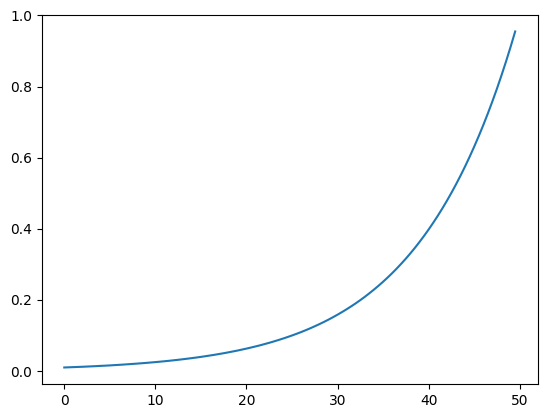

In [110]:
plt.plot(x, np.round(exponential_model(x, a=1, k=0.09210345, alpha=1) / 100, 4))

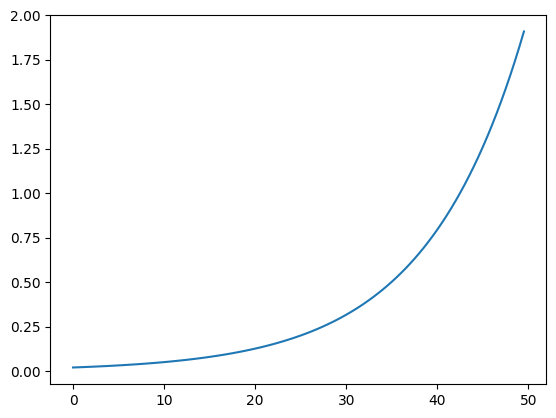

In [121]:
plt.plot(x, np.round(exponential_model(x, a=1, k=0.09210345, alpha=2) / 100, 4))

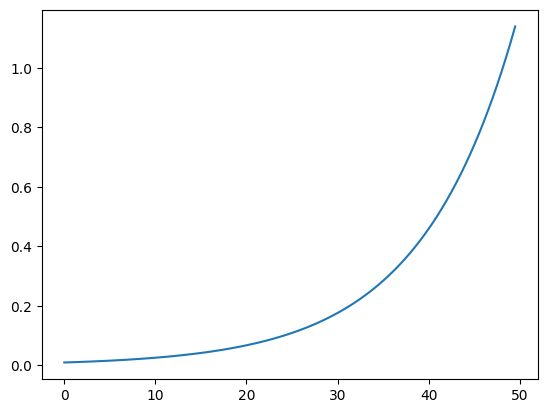

In [100]:
plt.plot(x, np.round(exponential_model_custom(x, a=1, base=2, k=0.138) / 100, 4))

In [163]:
res = [speedup_metric(item, max_speedup=50) for item in x]

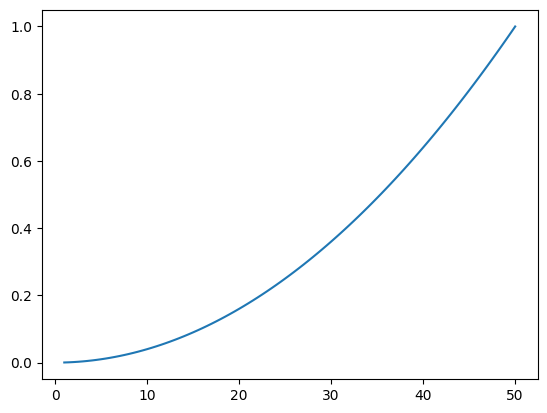

In [164]:
plt.plot(x, res)

In [322]:
res = [speedup_metric_current(speedUp=item, speedMax=50.) for item in x]

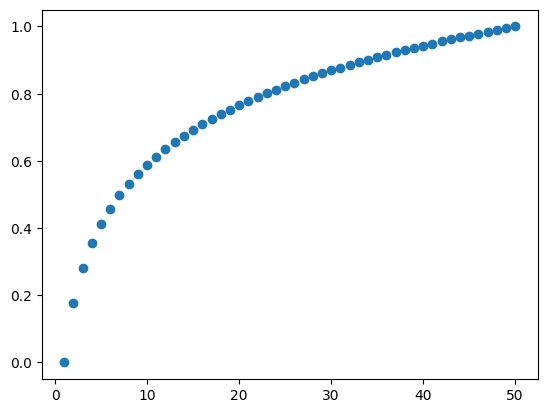

In [325]:
plt.scatter(x, res)

[0.02965208 0.04540524 0.05916917 0.07234256 0.08536376 0.09842801
 0.11163947 0.1250603  0.1387306  0.15267776 0.16692131 0.18147565
 0.19635176 0.21155812 0.2271015  0.24298733 0.25922007 0.27580339
 0.29274039 0.31003368 0.32768548 0.34569772 0.36407205 0.38280993
 0.40191263 0.42138127 0.44121685 0.46142025 0.48199227 0.50293361
 0.52424493 0.5459268  0.56797975 0.59040426 0.61320077 0.63636968
 0.65991136 0.68382615 0.70811436 0.73277627 0.75781217 0.78322229
 0.80900686 0.83516611 0.86170022 0.8886094  0.9158938  0.9435536
 0.97158895 1.        ]


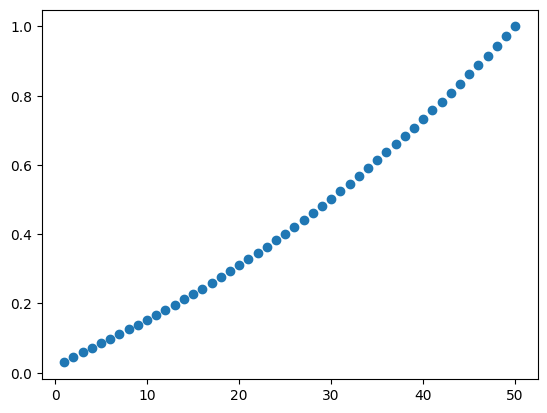

In [317]:
a=0.01 # 0.01
b=0.5 #0.5
c=0.1 #0.1
k=9
print(quadratic_func(x, a=a, b=b, c=c, k=k) / quadratic_func(50, a=a, b=b, c=c, k=k))
plt.scatter(x, quadratic_func(x, a=a, b=b, c=c, k=k) / quadratic_func(50, a=a, b=b, c=c, k=k))

[0.01217565 0.02275449 0.03373253 0.04510978 0.05688623 0.06906188
 0.08163673 0.09461078 0.10798403 0.12175649 0.13592814 0.150499
 0.16546906 0.18083832 0.19660679 0.21277445 0.22934132 0.24630739
 0.26367265 0.28143713 0.2996008  0.31816367 0.33712575 0.35648703
 0.3762475  0.39640719 0.41696607 0.43792415 0.45928144 0.48103792
 0.50319361 0.5257485  0.54870259 0.57205589 0.59580838 0.61996008
 0.64451098 0.66946108 0.69481038 0.72055888 0.74670659 0.77325349
 0.8001996  0.82754491 0.85528942 0.88343313 0.91197605 0.94091816
 0.97025948 1.        ]


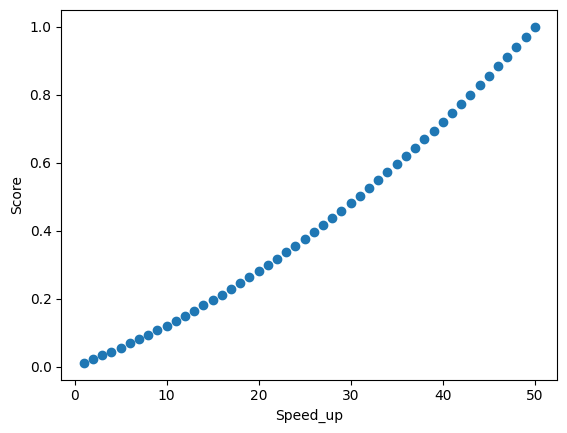

In [10]:
a=0.01 # 0.01
b=0.5 #0.5
c=0.1 #0.1
k=9
print(quadratic_func(x, a=a, b=b, c=c, k=k) / quadratic_func(50, a=a, b=b, c=c, k=k))
plt.scatter(x, quadratic_func(x, a=a, b=b, c=c, k=k) / quadratic_func(50, a=a, b=b, c=c, k=k))
plt.xlabel("Speed_up")
plt.ylabel("Score")
plt.show()

In [152]:
import numpy as np
def sigmodal(x):
    # return 1. / (1. + np.exp(-(x-a)))
    #return 1. / (1+np.exp(((-0.10001)*x) + np.e**(1.00001)))
    return 1. / (1+np.exp(-0.13*x + np.exp(0.6)))

In [153]:
x = np.arange(1, 50, 1)

In [154]:
sigmodal(x)

array([0.1554974 , 0.17334282, 0.19276877, 0.21380864, 0.23647221,
       0.26074138, 0.28656646, 0.31386342, 0.34251223, 0.37235692,
       0.40320735, 0.43484293, 0.46701826, 0.4994703 , 0.5319268 ,
       0.56411537, 0.59577254, 0.62665219, 0.65653284, 0.68522328,
       0.7125664 , 0.73844098, 0.76276182, 0.78547818, 0.80657097,
       0.82604911, 0.84394531, 0.86031169, 0.87521542, 0.88873469,
       0.90095502, 0.91196613, 0.92185927, 0.93072509, 0.93865194,
       0.94572465, 0.95202363, 0.95762433, 0.9625969 , 0.96700607,
       0.97091118, 0.97436634, 0.97742065, 0.98011845, 0.98249969,
       0.9846002 , 0.98645207, 0.98808395, 0.98952135])

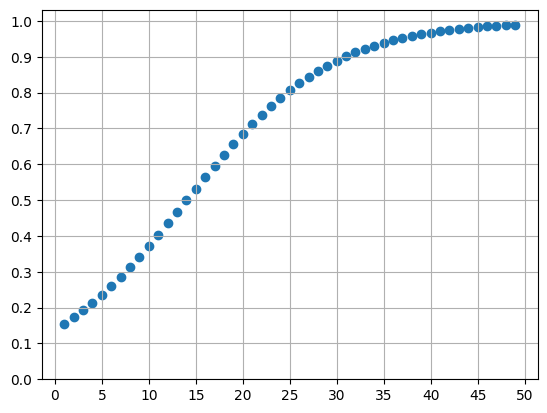

In [155]:
import matplotlib.pyplot as plt
plt.scatter(x, sigmodal(x))
plt.xticks(np.arange(0,51,5))
plt.yticks(np.arange(0, 1.1, 0.1))
#plt.xlim([0, 50])
plt.grid()


In [164]:
def weibull(c,b,x):
    a = c * ((-np.log(0.9)) ** (-1/b))
    return 1. - np.exp(-(x / a)**b)

In [202]:
weibull(5, 1.7, 10000) #/ weibull(5, 1.7, 50)

1.0

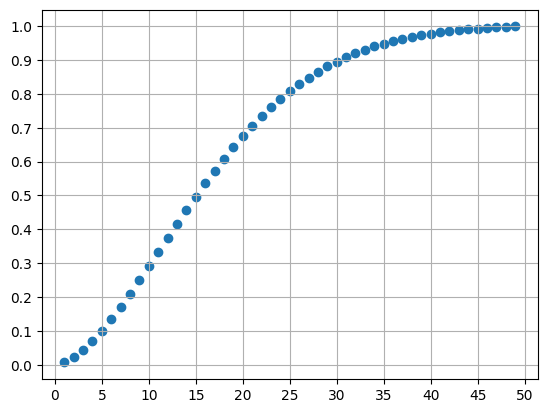

In [194]:
import matplotlib.pyplot as plt
plt.scatter(x, weibull(5, 1.7, x) / weibull(5, 1.7, 50))
plt.xticks(np.arange(0,51,5))
plt.yticks(np.arange(0, 1.1, 0.1))
#plt.xlim([0, 50])
plt.grid()

In [17]:
import math
c = 5
b = 1.7
a = c * ((-math.log(0.9)) ** (-1/1.7))
1. - math.exp(-(11.9 / a)**b)

0.3687838138900499

In [18]:
a

18.787343012482257

In [10]:
import math
import numpy as np
def nominator(x):
    return 0.01 * x**2 + 0.5 * x + 0.1 + np.log10(9*x)

def denominator(x=50):
    return 0.01 * x**2 + 0.5 * x + 0.1 + np.log10(9*x)

def speedup_score(x):
    return nominator(x) / denominator(x=50)

print(speedup_score(11.9))
0.4 * speedup_score(11.9)

0.18000589951469234


0.07200235980587694

In [20]:
0.3*.44 + .3*.33 + .4*.36

0.375

Padding and pooling

In [75]:
from tensorflow import keras

In [82]:
x = np.array([[1., 2., 3.],
              [4., 5., 6.],
              [7., 8., 9.]])
x = np.reshape(x, [1, 3, 3, 1])
avg_pool_2d = keras.layers.AveragePooling2D(pool_size=(2, 2),
   strides=(1, 1), padding="same")
print(avg_pool_2d(x))

tf.Tensor(
[[[[3. ]
   [4. ]
   [4.5]]

  [[6. ]
   [7. ]
   [7.5]]

  [[7.5]
   [8.5]
   [9. ]]]], shape=(1, 3, 3, 1), dtype=float32)


In [81]:
x

array([[[[1.],
         [2.],
         [3.]],

        [[4.],
         [5.],
         [6.]],

        [[7.],
         [8.],
         [9.]]]])